This is the integration test for BPReveal. It trains up an OSKN model and runs a full suite of analysis on it.

# Setup

In [1]:
import os
os.environ["PATH"] = os.environ["PATH"] + ":/n/apps/CentOS7/bin/"
import bpreveal.utils as utils
import bpreveal.tools.plots as bprplots
from bpreveal.tools.slurm import configSlurm, jobsNonGpu, jobsGpu, jobsLocal, writeDependencyScript
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams['figure.dpi'] = 150
import numpy as np
import pybedtools
import pysam
import pyBigWig
import h5py

In [2]:
BASE_DIRECTORY="/n/projects/cm2363/bpreveal"
WORKING_DIRECTORY=BASE_DIRECTORY + "/test/acceptance/oskn-4.1.4"
DATA_DIRECTORY=BASE_DIRECTORY + "/demoData/oskn"
SCRIPTS_DIR="/n/projects/cm2363/manuscript-bpreveal/src"
SLURM_CONFIG=configSlurm(["/home/cm2363/.zshrc"],
                         "/n/projects/cm2363/public-bpreveal/4.1.4/env", WORKING_DIRECTORY)
SLURM_CONFIG["gpuType"] = "l40"
GENOME_FASTA="/n/data1/genomes/indexes/mm10/mm10.fa"
TF_NAMES = ["oct4", "sox2", "klf4", "nanog"]
TEST_CHROMS = ["chr" + str(x) for x in [1, 8, 9]]
VAL_CHROMS = ["chr" + str(x) for x in [2,3,4]]
TRAIN_CHROMS = ["chr" + str(x) for x in [5,6,7,10,11,12,13,14,15,16,17,18,19]]
NUM_THREADS_MAJOR=70
NUM_THREADS_MINOR=20

NUM_EPOCHS = 200
LOG_LEVEL="DEBUG"

In [3]:
!mkdir -p {WORKING_DIRECTORY}/input
!mkdir -p {WORKING_DIRECTORY}/bed
!mkdir -p {WORKING_DIRECTORY}/json
!mkdir -p {WORKING_DIRECTORY}/logs
!mkdir -p {WORKING_DIRECTORY}/models
!mkdir -p {WORKING_DIRECTORY}/modisco
!mkdir -p {WORKING_DIRECTORY}/pred
!mkdir -p {WORKING_DIRECTORY}/shap
!mkdir -p {WORKING_DIRECTORY}/slurm
!mkdir -p {WORKING_DIRECTORY}/scan



In [4]:
with open(WORKING_DIRECTORY + "/slurm/.coveragerc", "w") as fp:
    fp.write(
        "[run]\n"
        "branch = True\n"
        "concurrency = multiprocessing\n"
        "omit = /tmp/*\n"
        "disable_warnings =\n"
        "    module-not-measured\n"
        "    module-not-imported\n"
        "parallel = true\n"
        "source = /n/projects/cm2363/bpreveal/src\n    bpreveal\n"
        "\n[report]\n"
        "exclude_also =\n    assert\n")


In [5]:
#Start building a list of jobs to run with dependencies
jobSpecs = []

# Length calc

In [6]:
OUTPUT_LENGTH=1000
CONV1_SIZE=7
PROFILE_CONV_SIZE=7
input_length_str = !lengthCalc --output-len {OUTPUT_LENGTH} \
                               --n-dil-layers 9 \
                               --conv1-kernel-size {CONV1_SIZE} \
                               --profile-kernel-size {PROFILE_CONV_SIZE}
INPUT_LENGTH=int(input_length_str[0])
print(INPUT_LENGTH)
RECEPTIVE_FIELD=INPUT_LENGTH - OUTPUT_LENGTH + 1
print(RECEPTIVE_FIELD)
BUFFER = (INPUT_LENGTH - OUTPUT_LENGTH) // 2
print(BUFFER)
MAX_JITTER = 100

3056
2057
1028


In [7]:
slurmNameCheckLength = jobsNonGpu(SLURM_CONFIG,
    ["coverage run $(which lengthCalc) --output-len "
     "{0:d}  --n-dil-layers 9 --conv1-kernel-size 25 "
     "--profile-kernel-size 25".format(OUTPUT_LENGTH)], 
            "checkLengthCalc", 1, 1, "0:01:00")
jobSpecs.append([slurmNameCheckLength, []])

# Prepare bed

In [8]:
bigwigFileNames = [[DATA_DIRECTORY + "/" + tfName + "/counts." + strand + ".bw"  
                   for strand in ["pos", "neg"]]
                  for tfName in TF_NAMES]
summitBedFnames = [DATA_DIRECTORY + "/" + tfName + "/idr-optimal-set.summit.bed" 
                   for tfName in TF_NAMES]
summitBedFnames += [DATA_DIRECTORY + "/peaks-bak/" + tfName + ".bed"
                    for tfName in TF_NAMES]
headSpec = [{"bigwig-names" : flist, "max-quantile" : 1, "min-counts" : 1} 
          for flist in bigwigFileNames]


In [9]:
prepareBedPeaksConfig = {
    "heads" : headSpec, 
    "splits" : {"test-chroms"  : TEST_CHROMS, 
                "val-chroms"   : VAL_CHROMS,
                "train-chroms" : TRAIN_CHROMS,
                "regions" : summitBedFnames},
    "genome" : GENOME_FASTA,
    "output-length" : OUTPUT_LENGTH, 
    "input-length" : INPUT_LENGTH,
    "max-jitter" : MAX_JITTER,
    "output-prefix" : WORKING_DIRECTORY + "/bed/peak", 
    "resize-mode" : "center", 
    "remove-overlaps" : True,
    "overlap-max-distance" : 100,
    "num-threads" : NUM_THREADS_MAJOR,
    "verbosity" : LOG_LEVEL}

with open(WORKING_DIRECTORY + "/json/prepareBedPeaks.json", "w") as fp:
    json.dump(prepareBedPeaksConfig, fp, indent=4)


In [10]:
slurmNamePrepareBedPeaks = jobsNonGpu(SLURM_CONFIG, ["coverage run $(which prepareBed) {0:s}/json/prepareBedPeaks.json".format(WORKING_DIRECTORY)], 
            "prepareBedPeaks", NUM_THREADS_MAJOR, 50, "1:00:00")
jobSpecs.append([slurmNamePrepareBedPeaks, []])


# Tile Genome

In [11]:
backgroundBase = "coverage run $(which tileGenome) --genome {0:s} --output-length {1:d} --input-length {2:d} "\
                 "--chrom-edge-boundary 100000 --spacing 10000 --output-bed {3:s} "\
                 "{4:s} {5:s}"
blacklistArgs = "--blacklist {0:s} --blacklist {1:s}".format(
    WORKING_DIRECTORY + "/bed/peak_all.bed",
    WORKING_DIRECTORY + "/bed/peak_reject.bed")

chromArgs = ' '.join(["--allow-chrom {0:s}".format(c) for c in (TRAIN_CHROMS + TEST_CHROMS + VAL_CHROMS)])

cmdGenBackground = backgroundBase.format(
    GENOME_FASTA, OUTPUT_LENGTH, INPUT_LENGTH, WORKING_DIRECTORY + "/bed/tiling_all.bed",
    blacklistArgs, chromArgs)

slurmNameGenBackground = jobsNonGpu(SLURM_CONFIG, [cmdGenBackground], "genBackground", 1, 10, "1:00:00")
jobSpecs.append([slurmNameGenBackground, [slurmNamePrepareBedPeaks]])

In [12]:
biasBigwigFnames = [DATA_DIRECTORY + "/patchcap/counts." + strand + ".bw" 
                    for strand in ["pos", "neg"]]

In [13]:
biasHeadSpec = [{"bigwig-names" : flist, "max-quantile" : 0.6, "min-quantile" : 0.01} 
          for flist in bigwigFileNames]
biasHeadSpec = biasHeadSpec + [{"bigwig-names" : biasBigwigFnames, 
                            "max-quantile" : 0.95, 
                            "min-quantile" : 0.1} ]
prepareBedNonPeaksConfig = {
    "heads" : biasHeadSpec, 
    "splits" : {"test-chroms"  : TEST_CHROMS, 
                "val-chroms"   : VAL_CHROMS,
                "train-chroms" : TRAIN_CHROMS,
                "regions" : [WORKING_DIRECTORY + "/bed/tiling_all.bed"]},
    "genome" : GENOME_FASTA,
    "output-length" : OUTPUT_LENGTH,
    "input-length" : INPUT_LENGTH,
    "max-jitter" : MAX_JITTER,
    "output-prefix" : WORKING_DIRECTORY + "/bed/nonpeak", 
    "remove-overlaps" : False,
    "resize-mode" : "center",
    "num-threads" : NUM_THREADS_MAJOR,
    "verbosity" : LOG_LEVEL}

with open(WORKING_DIRECTORY + "/json/prepareBedNonPeaks.json", "w") as fp:
    json.dump(prepareBedNonPeaksConfig, fp)

In [14]:
slurmNamePrepareBedNonPeaks = jobsNonGpu(SLURM_CONFIG,
    ["coverage run $(which prepareBed) {0:s}/json/prepareBedNonPeaks.json".format(WORKING_DIRECTORY)], 
    "prepareBedNonPeaks", NUM_THREADS_MAJOR, 50, "1:00:00")
jobSpecs.append([slurmNamePrepareBedNonPeaks, [slurmNameGenBackground]])

# Building the training dataset

In [15]:
configFnames = []
for split in ["train", "val"]:
    for dataset in ["peak", "nonpeak"]:
        heads = []
        for tfId, tfName in enumerate(TF_NAMES):
            if(dataset == 'peak'):
                heads.append({
                    "revcomp-task-order" : "auto",
                    "bigwig-files" : bigwigFileNames[tfId]})
            else:
                heads.append({
                    "revcomp-task-order" : "auto",
                    "bigwig-files" : biasBigwigFnames})
        config = {"genome" : GENOME_FASTA, 
                  "input-length" : INPUT_LENGTH,
                  "output-length" : OUTPUT_LENGTH,
                  "max-jitter" : MAX_JITTER,
                  "regions" : WORKING_DIRECTORY + "/bed/" + dataset + "_" + split + ".bed",
                  "output-h5" : WORKING_DIRECTORY + "/input/" + dataset + "_" + split + ".h5",
                  "reverse-complement" : True,
                  "heads" : heads,
                  "verbosity" : LOG_LEVEL}
        configFname =WORKING_DIRECTORY + "/json/prepareInput" + dataset + "_" + split+ ".json" 
        with open(configFname, "w") as fp:
            json.dump(config, fp, indent=2)
        configFnames.append(configFname)
slurmNamePrepareTrainingData = jobsNonGpu(SLURM_CONFIG,
    ["coverage run $(which prepareTrainingData) {0:s}".format(configFname) 
                for configFname in configFnames], 
    "prepareTrainingData", 2, 20, "1:00:00")
jobSpecs.append([slurmNamePrepareTrainingData, [slurmNamePrepareBedNonPeaks]])
        



# Training the bias model

In [16]:

heads = []
for tfName in TF_NAMES:
    heads.append({"num-tasks" : 2, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "patchcap_" + tfName,
                  "counts-loss-weight" : 10,
                  "counts-loss-frac-target" : 0.1})

biasTrainConfig = {
    "settings" : {
        "output-prefix" : WORKING_DIRECTORY + "/models/solo", 
        "epochs" : NUM_EPOCHS,
        "max-jitter" : 100,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.004,
        "learning-rate-plateau-patience" : 5,
        "architecture" : {
            "architecture-name" : "bpnet", 
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH,
            "model-name" : "patchcap",
            "model-args" : "",
            "filters" : 16,
            "layers" : 9,
            "input-filter-width" : CONV1_SIZE,
            "output-filter-width" : PROFILE_CONV_SIZE
        }
    },
    "train-data" : WORKING_DIRECTORY + "/input/nonpeak_train.h5",
    "val-data" : WORKING_DIRECTORY + "/input/nonpeak_val.h5",
    "heads" : heads,
    "verbosity" : LOG_LEVEL
}


with open(WORKING_DIRECTORY + "/json/trainBias.json", "w") as fp:
    json.dump(biasTrainConfig, fp, indent=4)
    

In [17]:
slurmNameTrainSoloModel = jobsGpu(SLURM_CONFIG, ["coverage run $(which trainSoloModel) {0:s}".format(WORKING_DIRECTORY + "/json/trainBias.json")],
        "trainSolo", 10, 30, "10:00:00")
jobSpecs.append([slurmNameTrainSoloModel, [slurmNamePrepareTrainingData]])


# makePredictions

In [18]:

biasPredictConfig = {
    "settings" : {
        "output-h5" : WORKING_DIRECTORY + "/pred/patchcap.h5", 
        "batch-size" : 128,
        "heads" : len(TF_NAMES),
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/solo.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "genome" : GENOME_FASTA, 
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "num-threads" : 4,
    "verbosity" : LOG_LEVEL
}


with open(WORKING_DIRECTORY + "/json/predictBias.json", "w") as fp:
    json.dump(biasPredictConfig, fp)

In [19]:
slurmNamePredictSolo = jobsNonGpu(SLURM_CONFIG, ["coverage run $(which makePredictions) {0:s}".format(WORKING_DIRECTORY + "/json/predictBias.json")],
        "predictSolo", 3, 50, "10:00:00")
jobSpecs.append([slurmNamePredictSolo, [slurmNameTrainSoloModel]])

# PredictToBigwig

In [20]:

predCmd = "coverage run $(which predictToBigwig) " +\
          "--h5 {0:s}/pred/patchcap.h5 " +\
          "--bw {0:s}/pred/patchcap_{1:s}.bw "+\
          "--head-id 0 --task-id {2:d} --mode profile "+\
          "--threads {3:d}"

slurmNamePredToBigwigBias = jobsNonGpu(SLURM_CONFIG, [predCmd.format(WORKING_DIRECTORY, strand[0], strand[1], NUM_THREADS_MINOR) for strand in [("positive", 0), ("negative", 1)]], 
           "predToBigwigBias", NUM_THREADS_MINOR, 20, "1:00:00")
jobSpecs.append([slurmNamePredToBigwigBias, [slurmNamePredictSolo]])

# makeLossPlots

In [21]:
cmdLossPlots = "coverage run $(which makeLossPlots) --json {0:s}/models/solo.history.json --output {0:s}/models/solo.png".format(WORKING_DIRECTORY)
slurmNameLossPlotsSolo = jobsNonGpu(SLURM_CONFIG, [cmdLossPlots], "lossPlots", 1, 20, "1:00:00")
jobSpecs.append([slurmNameLossPlotsSolo, [slurmNameTrainSoloModel]])

# Training the transformation model

In [22]:
heads = []
for tfName in TF_NAMES:
    heads.append({"num-tasks" : 2, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "patchcap_" + tfName,
                  "counts-loss-weight" : 100,
                  "counts-loss-frac-target" : 0.1})

transformationTrainConfig = {
    "settings" : {
        "output-prefix" : WORKING_DIRECTORY + "/models/transformation", 
        "epochs" : NUM_EPOCHS,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.04,
        "learning-rate-plateau-patience" : 5,
        "solo-model-file" : WORKING_DIRECTORY + "/models/solo.model",
        "input-length" : INPUT_LENGTH, 
        "output-length" : OUTPUT_LENGTH,
        "max-jitter" : 100,
        "profile-architecture" : {
            "name" : "simple", 
            "types" : ["linear", "sigmoid"]},
        "counts-architecture" : {
            "name" : "simple", 
            "types" : ["linear", "sigmoid"]}},
        
    "train-data" : WORKING_DIRECTORY+ "/input/peak_train.h5",
    "val-data" : WORKING_DIRECTORY + "/input/peak_val.h5",
    "heads" : heads,
    "verbosity" : LOG_LEVEL
}
with open(WORKING_DIRECTORY + "/json/trainTransformation.json", "w") as fp:
    json.dump(transformationTrainConfig, fp)

In [23]:
slurmNameTrainTransformation = jobsGpu(SLURM_CONFIG, 
    ["coverage run $(which trainTransformationModel) {0:s}".format(WORKING_DIRECTORY + "/json/trainTransformation.json")],
        "trainTransformation", 10, 60, "10:00:00")
jobSpecs.append([slurmNameTrainTransformation, [slurmNameTrainSoloModel]])

# Transformation prediction

In [24]:
transformPredictConfig = {
    "settings" : {
        "output-h5" : WORKING_DIRECTORY + "/pred/transform.h5", 
        "batch-size" : 128,
        "heads" : len(TF_NAMES),
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/transformation.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "genome" : GENOME_FASTA, 
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "num-threads" : 1,
    "verbosity" : LOG_LEVEL
}


with open(WORKING_DIRECTORY + "/json/predictTransformation.json", "w") as fp:
    json.dump(transformPredictConfig, fp)


In [25]:
slurmNamePredictTransformation = jobsNonGpu(SLURM_CONFIG, 
    ["coverage run $(which makePredictions) {0:s}".format(WORKING_DIRECTORY + "/json/predictTransformation.json")],
        "predictTransformation", 2, 50, "10:00:00")
jobSpecs.append([slurmNamePredictTransformation, [slurmNameTrainTransformation]])
predCmd = "coverage run $(which predictToBigwig) " +\
          "--h5 {0:s}/pred/transform.h5 " +\
          "--bw {0:s}/pred/transform_{1:s}.bw "+\
          "--head-id 0 --task-id {2:d} --mode profile "+\
          "--threads {3:d}"

slurmNamePredToBigwigTransformation = jobsNonGpu(SLURM_CONFIG,
    [predCmd.format(WORKING_DIRECTORY, strand[0], strand[1], NUM_THREADS_MINOR) for strand in [("positive", 0), ("negative", 1)]], 
    "predToBigwigTransform", NUM_THREADS_MINOR, 20, "1:00:00")
jobSpecs.append([slurmNamePredToBigwigTransformation, [slurmNamePredictTransformation]])

# Training the combined model

In [26]:
heads = []
for i, tfName in enumerate(TF_NAMES):
    heads.append({"num-tasks" : 2, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "combined_" + tfName,
                  "counts-loss-weight" : 100,
                  "counts-loss-frac-target" : 0.1,
                  "use-bias-counts" : i == 0 # Just to test the system, there's no reason to do this in a real model.
                 })

combinedTrainConfig = {
    "settings" : {
        "output-prefix" : WORKING_DIRECTORY + "/models/joint", 
        "epochs" : NUM_EPOCHS,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.004,
        "learning-rate-plateau-patience" : 5,
        "max-jitter" : 100,
        "transformation-model" : {
            "transformation-model-file" : WORKING_DIRECTORY + "/models/transformation.model"
        },
        "architecture" : {
            "architecture-name" : "bpnet", 
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH,
            "model-name" : "joint",
            "model-args" : "",
            "filters" : 64,
            "layers" : 9,
            "input-filter-width" : 7,
            "output-filter-width" : 7
        }
    },
    "train-data" : WORKING_DIRECTORY + "/input/peak_train.h5",
    "val-data" : WORKING_DIRECTORY + "/input/peak_val.h5",
    "heads" : heads,
    "verbosity" : "DEBUG" # I need some debug output to test showTrainingProgress.
}


with open(WORKING_DIRECTORY + "/json/trainCombined.json", "w") as fp:
    json.dump(combinedTrainConfig, fp)

In [27]:

slurmNameTrainCombined = jobsGpu(SLURM_CONFIG, ["coverage run $(which trainCombinedModel) {0:s}".format(WORKING_DIRECTORY + "/json/trainCombined.json")],
        "trainCombined", 10, 60, "10:00:00")
jobSpecs.append([slurmNameTrainCombined, [slurmNameTrainTransformation]])

# Predict combined

In [28]:
combinedPredictConfig = {
    "settings" : { 
        "output-h5" : WORKING_DIRECTORY + "/pred/combined.h5", 
        "batch-size" : 128,
        "heads" : len(TF_NAMES),
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/joint_combined.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "genome" : GENOME_FASTA,
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "num-threads" : 2,
    "verbosity" : LOG_LEVEL
}
with open(WORKING_DIRECTORY + "/json/predictCombined.json", "w") as fp:
    json.dump(combinedPredictConfig, fp)
#For the residual model, I just need to change a few terms:
residualPredictConfig = combinedPredictConfig
residualPredictConfig["settings"]["output-h5"] = WORKING_DIRECTORY + "/pred/residual.h5"
residualPredictConfig["settings"]["architecture"]["model-file"] = WORKING_DIRECTORY + "/models/joint_residual.model"
with open(WORKING_DIRECTORY + "/json/predictResidual.json", "w") as fp:
    json.dump(residualPredictConfig, fp)

In [29]:
slurmNamePredictCombined = jobsGpu(SLURM_CONFIG, 
    ["coverage run $(which makePredictions) {0:s}".format(WORKING_DIRECTORY + "/json/predictCombined.json"),
     "coverage run $(which makePredictions) {0:s}".format(WORKING_DIRECTORY + "/json/predictResidual.json")],
    "predictCombined", 1, 50, "10:00:00")
jobSpecs.append([slurmNamePredictCombined, [slurmNameTrainCombined]])

bwCmdBase = "coverage run $(which predictToBigwig) " +\
          "--h5 {wd:s}/pred/{inf:s}.h5 " +\
          "--bw {wd:s}/pred/{outf:s}.bw "+\
          "--head-id {hid:d} --task-id {tid:d} --mode profile "+\
          "--threads {nt:d}"
bwCmds = []
for modelType in ["residual", "combined"]:
    for headid, tfname in enumerate(TF_NAMES):
        for tid, strand in enumerate(["positive", "negative"]):
            cmd = bwCmdBase.format(wd=WORKING_DIRECTORY, 
                                   inf=modelType,
                                   outf=tfname + "_" + modelType + "_" + strand,
                                   hid=headid, tid=tid,
                                   nt=NUM_THREADS_MINOR)
            bwCmds.append(cmd)

slurmNamePredToBigwigCombined = jobsNonGpu(SLURM_CONFIG, bwCmds, 
           "predToBigwigCombined", NUM_THREADS_MINOR, 20, "1:00:00")

jobSpecs.append([slurmNamePredToBigwigCombined, [slurmNamePredictCombined]])

# Deriving flat importance scores

In [30]:
def makeInterpretJson(tfNum):
    return {
        "genome" : GENOME_FASTA,
        "bed-file" : WORKING_DIRECTORY + "/bed/peak_test.bed",
        "model-file" : WORKING_DIRECTORY + "/models/joint_residual.model", 
        "input-length" : INPUT_LENGTH,
        "output-length" : OUTPUT_LENGTH,
        "heads" : len(TF_NAMES),
        "head-id": tfNum,
        "profile-task-ids" : [0,1],
        "profile-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_profile.h5",
        "counts-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_counts.h5",
        "num-shuffles" : 20,
        "kmer-size" : tfNum + 1, # Just to exercise the code path.
        "verbosity" : LOG_LEVEL}
cmds = []
for tfNum in range(len(TF_NAMES)):
    fname = WORKING_DIRECTORY + "/json/shap_" + TF_NAMES[tfNum] + ".json"
    cmds.append("coverage run $(which interpretFlat) {0:s}".format(fname))
    with open(fname, "w") as fp:
        json.dump(makeInterpretJson(tfNum), fp)
slurmNameInterpretFlat = jobsGpu(SLURM_CONFIG, cmds,
        "interpretFlat", 5, 50, "10:00:00")
jobSpecs.append([slurmNameInterpretFlat, [slurmNameTrainCombined]])

In [31]:
shapBwCmdBase = "coverage run $(which shapToBigwig) " +\
          "--h5 {wd:s}/shap/{tf:s}_{readout:s}.h5 " +\
          "--bw {wd:s}/shap/{tf:s}_{readout:s}.bw "
shapBwCmds = []
for tfname in TF_NAMES:
    for readout in ["profile", "counts"]:
        cmd = shapBwCmdBase.format(wd=WORKING_DIRECTORY, 
                                   tf=tfname,
                                   readout=readout)
        shapBwCmds.append(cmd)

slurmNameShapToBigwig = jobsNonGpu(SLURM_CONFIG, shapBwCmds, 
           "shapToBigwig", 2, 20, "1:00:00")
jobSpecs.append([slurmNameShapToBigwig, [slurmNameInterpretFlat]])


# ShapToNumpy

In [32]:

shapToNumpyCmdBase = "coverage run $(which shapToNumpy) " +\
          "--h5 {wd:s}/shap/{tf:s}_{readout:s}.h5 " +\
          "--seqs {wd:s}/shap/seqs_{tf:s}_{readout:s}.npz "+\
          "--scores {wd:s}/shap/scores_{tf:s}_{readout:s}.npz "
shapToNumpyCmds = []
for tfname in TF_NAMES:
    for readout in ["profile", "counts"]:
        cmd = shapToNumpyCmdBase.format(wd=WORKING_DIRECTORY, 
                                        tf=tfname,
                                        readout=readout)
        shapToNumpyCmds.append(cmd)

slurmNameShapToNumpy = jobsNonGpu(SLURM_CONFIG, shapToNumpyCmds, 
           "shapToNumpy", 2, 20, "1:00:00")
jobSpecs.append([slurmNameShapToNumpy, [slurmNameInterpretFlat]])

# Modisco

In [33]:
modiscoCmdBase = "mkdir -p {wd:s}/modisco/{tf:s}_{readout:s}\n" +\
          "modisco motifs " +\
              "-s {wd:s}/shap/seqs_{tf:s}_{readout:s}.npz " +\
              "-a {wd:s}/shap/scores_{tf:s}_{readout:s}.npz "+\
              "-n 2000 " +\
              "-w 1000 "+\
              "-o {wd:s}/modisco/{tf:s}_{readout:s}/modisco.h5 "
modiscoCmds = []
for tfname in TF_NAMES:
    for readout in ["profile", "counts"]:
        cmd = modiscoCmdBase.format(wd=WORKING_DIRECTORY, 
                                        tf=tfname,
                                        readout=readout)
        modiscoCmds.append(cmd)

slurmNameModisco = jobsNonGpu(SLURM_CONFIG, modiscoCmds, 
           "modisco", 70, 600, "10:00:00")
jobSpecs.append([slurmNameModisco, [slurmNameShapToNumpy]])

In [34]:
reportCmdBase = "modisco report " +\
              "-i {wd:s}/modisco/{tf:s}_{readout:s}/modisco.h5 " +\
              "-o {wd:s}/modisco/{tf:s}_{readout:s}/ "+\
              "-n 2 " +\
              "-m /n/data1/JASPAR/2022/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt " +\
              "\n\n{sd:s}/annotateModiscoHtml " +\
              " {wd:s}/modisco/{tf:s}_{readout:s}/motifs.html " + \
              " > {wd:s}/modisco/{tf:s}_{readout:s}/motifs_names.html"
              
reportCmds = []
for tfname in TF_NAMES:
    for readout in ["profile", "counts"]:
        cmd = reportCmdBase.format(wd=WORKING_DIRECTORY, 
                                        sd=SCRIPTS_DIR,
                                        tf=tfname,
                                        readout=readout)
        reportCmds.append(cmd)

slurmNameModiscoReport = jobsNonGpu(SLURM_CONFIG, reportCmds, 
           "modiscoReport", 5, 5, "1:00:00")
jobSpecs.append([slurmNameModiscoReport, [slurmNameModisco]])

# Making a PISA plot

In [35]:
windowStart = 180924752-1000
windowEnd = 180925152+1000
windowLen = windowEnd - windowStart
windowChrom = "chr1"

In [36]:

def writeRegion(genome, outFp, regionStart):
    genomeStart = regionStart - BUFFER
    genomeEnd = genomeStart + INPUT_LENGTH
    seq = genome.fetch(windowChrom, genomeStart, genomeEnd)
    outFp.write(">{0:d}\n".format(regionStart))
    outFp.write(seq.upper())
    outFp.write("\n")

with open(WORKING_DIRECTORY + "/shap/pisa_regions.fa", "w") as fp:
    with pysam.FastaFile(GENOME_FASTA) as genome:
        for regionStart in range(windowStart, windowEnd):
            writeRegion(genome, fp, regionStart)


In [37]:

cmds = []
for tfid in range(len(TF_NAMES)):
    for strand in [0,1]:
        task_name = TF_NAMES[tfid] + "_" + ["positive", "negative"][strand]
        pisa_config = {"model-file" : WORKING_DIRECTORY + "/models/joint_residual.model", 
                       "fasta-file" : WORKING_DIRECTORY + "/shap/pisa_regions.fa", 
                       "num-shuffles" : 20, 
                       "head-id" : tfid,
                       "task-id" : strand,
                       "output-h5" : WORKING_DIRECTORY + "/shap/pisa_" + task_name + ".h5",
                       "input-length" : INPUT_LENGTH,
                       "output-length" : OUTPUT_LENGTH,
                       "kmer-size" : strand + 1, # Just to exercise both possibilities.
                       "num-threads" : strand + 1,
                       "make-predictions" : True,
                       "correct-receptive-field": True,
                       "verbosity" : LOG_LEVEL}
        jsonFname = WORKING_DIRECTORY + "/json/pisa_" + task_name + ".json"
        with open(jsonFname, "w") as fp:
            json.dump(pisa_config, fp)
        cmds.append("coverage run $(which interpretPisa) {0:s}".format(jsonFname))

slurmNameInterpretPisa = jobsGpu(SLURM_CONFIG, cmds, "interpretPisa", 5, 20, "10:00:00")
jobSpecs.append([slurmNameInterpretPisa, [slurmNameTrainCombined]])

# Metrics

In [38]:
metricsCmdBase = ("coverage run $(which metrics) --reference {ddir:s}/{tf:s}/counts.{strand:s}.bw "
         "--pred {wd:s}/pred/{tf:s}_combined_{longstrand:s}.bw "
         "--regions {wd:s}/bed/peak_all.bed "
         "--threads {nt:d} --apply-abs --skip-zeroes")
cmds = []
for tfName in TF_NAMES:
    for lstr, sstr in (("positive", "pos"), ("negative", "neg")):
        metricsCmd = metricsCmdBase.format(wd = WORKING_DIRECTORY, ddir=DATA_DIRECTORY, 
                                           tf=tfName, strand = sstr, longstrand=lstr,
                                           nt=NUM_THREADS_MINOR)
        cmds.append(metricsCmd)
slurmNameMetrics = jobsNonGpu(SLURM_CONFIG, cmds, "metrics", NUM_THREADS_MINOR, 20, "1:00:00")
jobSpecs.append([slurmNameMetrics, [slurmNamePredToBigwigCombined]])

# showModel

In [39]:
slurmNameShowModel = jobsNonGpu(SLURM_CONFIG,
    [("coverage run $(which showModel) --model {wd:s}/models/joint_combined.model "
     "--png {wd:s}/models/joint_combined.png").format(wd=WORKING_DIRECTORY)], 
            "checkShowModel", 1, 1, "0:05:00")
jobSpecs.append([slurmNameShowModel, [slurmNameTrainCombined]])

# checkJson

In [40]:
slurmNameCheckJson = jobsNonGpu(SLURM_CONFIG,
    [("coverage run $(which checkJson) {wd:s}/json/prepareBedNonPeaks.json").format(wd=WORKING_DIRECTORY),
     ("coverage run $(which checkJson) -s prepareBed {wd:s}/json/prepareBedNonPeaks.json").format(wd=WORKING_DIRECTORY)], 
            "checkCheckJson", 1, 1, "0:05:00")
jobSpecs.append([slurmNameCheckJson, []])

# Easy functions

In [41]:
with open(WORKING_DIRECTORY + "/slurm/testEasy.py", "w") as fp:
    prog = ("#!/usr/bin/env python3\nfrom bpreveal import utils\nimport random\n"
            "utils.setVerbosity('WARNING')\n"
            "import os\nos.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'\n"
            "seq=''.join(random.choices('ACGT', k={isize:d}))\n"
            "utils.easyPredict(seq, '{wd:s}/models/joint_combined.model')\n"
            "utils.easyInterpretFlat(seq, '{wd:s}/models/joint_residual.model', "
            "{nh:d}, 0, [0,1])\n").format(wd=WORKING_DIRECTORY, isize=INPUT_LENGTH,
                                         nh = len(TF_NAMES))
    fp.write(prog)
slurmNameCheckEasy = jobsGpu(SLURM_CONFIG,
    [("coverage run {wd:s}/slurm/testEasy.py").format(wd=WORKING_DIRECTORY)], 
            "checkEasy", 3, 20, "0:15:00")
jobSpecs.append([slurmNameCheckEasy, [slurmNameTrainCombined]])

In [42]:
with open(WORKING_DIRECTORY + "/slurm/testEasyCpu.py", "w") as fp:
    prog = ("#!/usr/bin/env python3\nfrom bpreveal import utils\nimport random\n"
            "utils.setVerbosity('WARNING')\n"
            "import os\nos.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'\n"
            "seq=''.join(random.choices('ACGT', k={isize:d}))\n"
            "utils.easyPredict(seq, '{wd:s}/models/joint_combined.model')\n"
           ).format(wd=WORKING_DIRECTORY, isize=INPUT_LENGTH)
    fp.write(prog)
slurmNameCheckEasyCpu = jobsNonGpu(SLURM_CONFIG,
    [("coverage run {wd:s}/slurm/testEasyCpu.py").format(wd=WORKING_DIRECTORY)], 
            "checkEasy", 3, 20, "0:15:00")
jobSpecs.append([slurmNameCheckEasyCpu, [slurmNameTrainCombined]])

# Motif scanning

In [43]:
bgProbs = [(1-0.42) /2, 0.21, 0.21, (1-0.42) /2]
patternsToScan = {}
for tf in TF_NAMES:
    for mode in ["profile", "counts"]:
        patNames = [[x, tf[0] + mode[0] + str(x)] for x in range(5)]
        patternsToScan[tf + "_" + mode] = {"pos": patNames} 


In [44]:

cmds = []
SCAN_BASE = "coverage run $(which motifSeqletCutoffs) {cutoffFname:s} \n" +\
            "coverage run $(which motifScan) {scanFname:s} \n    " +\
            "coverage run $(which motifAddQuantiles) --seqlet-tsv {seqletTsv:s} --scan-tsv {scanTsv:s}\n" +\
            "   cat {scanTsv:s} | " + \
                "cut -f 1-6 | " + \
                "tail -n +2 | " + \
                "sort -k1,1 -k2,2n -k3,3n -k4,4 -k5,5nr | "+\
                "awk '!_[$1,$2,$3,$4,$6]++' > {scanBed:s}\n"+\
            "   cat {seqletTsv:s} | cut -f 1-6 | tail -n +2 > {seqletBed:s}"

for pat in patternsToScan.keys():
    curPats = patternsToScan[pat]
    patternSpec = []
    for mcName in curPats.keys():
        patternSpec.append({
            "metacluster-name" : mcName + "_patterns", 
            "pattern-names" : ["pattern_{0:d}".format(x[0]) for x in curPats[mcName]],
            "short-names" : [x[1] for x in curPats[mcName]]})
    seqletTsv =  WORKING_DIRECTORY + "/modisco/" + pat + "/seqlets_" + pat + ".tsv"
    seqletBed = WORKING_DIRECTORY + "/modisco/" + pat + "/seqlets_" + pat + ".bed"
    hitsTsv = WORKING_DIRECTORY + "/scan/" + pat + ".tsv"
    hitsBed = WORKING_DIRECTORY + "/scan/" + pat + ".bed"
    cutoffConfigDict = {
            "seqlets-tsv" : seqletTsv,
            "modisco-h5" : WORKING_DIRECTORY + "/modisco/" + pat + "/modisco.h5",
            "modisco-contrib-h5" : WORKING_DIRECTORY + "/shap/" + pat + ".h5",
            "patterns" : patternSpec, 
            "seq-match-quantile" : 0.2,
            "contrib-match-quantile" : 0.2,
            "contrib-magnitude-quantile" : 0.2,
            "trim-threshold" : 0.3,
            "trim-padding" : 1,
            "background-probs" : bgProbs,
            "modisco-window": 1000,
            "quantile-json" : WORKING_DIRECTORY + "/scan/" + pat + "_motifs.json",
            "verbosity" : LOG_LEVEL}
    
    scanConfigDict = {
        "scan-settings" : {
            "scan-contrib-h5" : WORKING_DIRECTORY + "/shap/" + pat + ".h5",
            "hits-tsv" : hitsTsv,
            "num-threads" : 70},
        "seqlet-cutoff-json" : WORKING_DIRECTORY + "/scan/" + pat + "_motifs.json",
        "verbosity" : LOG_LEVEL}
    scanFname = WORKING_DIRECTORY + "/json/scan_" + pat + ".json"
    cutoffFname = WORKING_DIRECTORY + "/json/cutoffs_" + pat + ".json"
    cmdStr = SCAN_BASE.format(scanFname = scanFname, cutoffFname = cutoffFname, seqletTsv = seqletTsv,
                              scanTsv = hitsTsv, scanBed = hitsBed, seqletBed = seqletBed)
    cmds.append(cmdStr)
    with open(scanFname, "w") as fp:
        json.dump(scanConfigDict, fp, indent=4)
    with open(cutoffFname, "w") as fp:
        json.dump(cutoffConfigDict, fp, indent=4)
slurmNameScan = jobsNonGpu(SLURM_CONFIG, cmds, "motifScan", 70, 10, "10:00:00")

In [45]:
jobSpecs.append([slurmNameScan, [slurmNameModisco]])

# Interpret from fasta

In [46]:
def writeRegion(genome, outFp, regionStart):
    genomeStart = regionStart - 1046
    genomeEnd = genomeStart + INPUT_LENGTH
    seq = genome.fetch(windowChrom, genomeStart, genomeEnd)
    outFp.write(">{0:d}\n".format(regionStart))
    outFp.write(seq.upper())
    outFp.write("\n")

with open(WORKING_DIRECTORY + "/shap/interp_regions.fa", "w") as fafp, \
     open(WORKING_DIRECTORY + "/bed/interp.bed", "w") as bedfp:
    with pysam.FastaFile(GENOME_FASTA) as genome:
        for regionStart in range(windowStart, windowEnd + 1000, 1000):
            writeRegion(genome, fafp, regionStart)
            bedfp.write("chr1\t{0:d}\t{1:d}\n".format(regionStart, regionStart + 1000))

In [47]:
def makeInterpretFastaJson(tfNum):
    return {
        "fasta-file" : WORKING_DIRECTORY + "/shap/interp_regions.fa",
        "coordinates": {
            "bed-file" : WORKING_DIRECTORY + "/bed/interp.bed",
            "genome" : GENOME_FASTA},
        "model-file" : WORKING_DIRECTORY + "/models/joint_residual.model",
        "input-length" : INPUT_LENGTH,
        "output-length" : OUTPUT_LENGTH,
        "heads" : len(TF_NAMES),
        "head-id": tfNum,
        "profile-task-ids" : [0,1],
        "profile-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_fasta_profile.h5",
        "counts-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_fasta_counts.h5",
        "num-shuffles" : 20,
        "verbosity" : LOG_LEVEL}

cmds = []
fname = WORKING_DIRECTORY + "/json/shap_fasta_" + TF_NAMES[0] + ".json"
cmds.append("coverage run $(which interpretFlat) {0:s}".format(fname))
with open(fname, "w") as fp:
    json.dump(makeInterpretFastaJson(0), fp)

slurmNameInterpretFastaFlat = jobsGpu(SLURM_CONFIG, cmds,
        "interpretFastaFlat", 5, 50, "1:00:00")
jobSpecs.append([slurmNameInterpretFastaFlat, [slurmNameTrainCombined]])

In [48]:
shapBwCmdBase = "coverage run $(which shapToBigwig) " +\
          "--h5 {wd:s}/shap/oct4_fasta_profile.h5 " +\
          "--bw {wd:s}/shap/oct4_fasta_profile.bw "
shapBwCmds = []
cmd = shapBwCmdBase.format(wd=WORKING_DIRECTORY)
shapBwCmds.append(cmd)

slurmNameShapFastaToBigwig = jobsNonGpu(SLURM_CONFIG, shapBwCmds, 
           "shapFastaToBigwig", 2, 20, "1:00:00")
jobSpecs.append([slurmNameShapFastaToBigwig, [slurmNameInterpretFastaFlat]])

## Predict from fasta

In [49]:
def makePredictFastaJson(tfNum):
    return {
        "settings" : {
            "output-h5": WORKING_DIRECTORY + "/pred/from_fasta.h5",
            "batch-size" : 8,
            "heads" : len(TF_NAMES),
            "architecture": {
                "model-file" : WORKING_DIRECTORY + "/models/joint_combined.model",
                "input-length" : INPUT_LENGTH,
                "output-length" : OUTPUT_LENGTH
            },
        },      
        "fasta-file" : WORKING_DIRECTORY + "/shap/interp_regions.fa",
        "coordinates": {
            "bed-file" : WORKING_DIRECTORY + "/bed/interp.bed",
            "genome" : GENOME_FASTA},
        "num-threads": 2,
        "verbosity" : LOG_LEVEL}

cmds = []
fname = WORKING_DIRECTORY + "/json/predict_fasta_" + TF_NAMES[0] + ".json"
cmds.append("coverage run $(which makePredictions) {0:s}".format(fname))
with open(fname, "w") as fp:
    json.dump(makePredictFastaJson(0), fp)

slurmNamePredictFasta = jobsGpu(SLURM_CONFIG, cmds,
        "predictFasta", 5, 50, "1:00:00")
jobSpecs.append([slurmNamePredictFasta, [slurmNameTrainCombined]])

## Run the GA

In [50]:
cmdsRunGa = []
cmdsRunGa.append(f"coverage run {BASE_DIRECTORY}/doc/demos/runGa.py --start 34066036 --input-len {INPUT_LENGTH} \
                   --chrom chr1 --model {WORKING_DIRECTORY}/models/joint_residual.model --genome {GENOME_FASTA} \
                   --output {WORKING_DIRECTORY}/logs/gaOutput.json")
slurmNameRunGa = jobsGpu(SLURM_CONFIG, cmdsRunGa, "runGa", 5, 50, "0:10:00")
jobSpecs.append([slurmNameRunGa, [slurmNameTrainCombined]])

In [51]:
# Last thing: the output reader for training outputs.
# Note that this must be run with an interactive terminal!
cmds = []
cmds.append(f"cat {WORKING_DIRECTORY}/logs/$(ls {WORKING_DIRECTORY}/logs | grep trainCombined | tail -n 1) | \
              coverage run $(which showTrainingProgress)")
cmds.append("coverage combine")
cmds.append("coverage html")
jobsLocal(SLURM_CONFIG, cmds, "finalize", 1, 1, "0:01:00");

# Write entire script.

In [52]:
def getScriptName(longName):
    return longName.split('/')[-1][:-6]
lastChild = ""
for e in jobSpecs:
    parents = [getScriptName(x) for x in e[1]]
    child = getScriptName(e[0])
    if len(parents) == 1 and parents[0] == lastChild:
        parents = '""'
    print("{0:25s}    {1:20s}".format(str(parents), child))
    lastChild = child
    

[]                           checkLengthCalc     
[]                           prepareBedPeaks     
""                           genBackground       
""                           prepareBedNonPeaks  
""                           prepareTrainingData 
""                           trainSolo           
""                           predictSolo         
""                           predToBigwigBias    
['trainSolo']                lossPlots           
['trainSolo']                trainTransformation 
""                           predictTransformation
""                           predToBigwigTransform
['trainTransformation']      trainCombined       
""                           predictCombined     
""                           predToBigwigCombined
['trainCombined']            interpretFlat       
""                           shapToBigwig        
['interpretFlat']            shapToNumpy         
""                           modisco             
""                           modiscoReport      

In [53]:
writeDependencyScript(SLURM_CONFIG, jobSpecs, "acceptance", cancelScript = WORKING_DIRECTORY + "/slurm/cancel.zsh")

In [54]:
1/0 # STOP HERE.

ZeroDivisionError: division by zero

# Analysis

In [55]:
#Let's also take a quick look at the generated bigwigs. 

def plotBws(bwNames, titles, chrom, start, stop):
    
    for i, bwName in enumerate(bwNames):
        plt.subplot(100*len(bwNames)+10+(i+1))
        bw = pyBigWig.open(bwName)
        bwVals = np.nan_to_num(bw.values(chrom, start, stop))
        #plt.xlim(0,stop-start)
        plt.bar(range(start, stop), bwVals, width=1)
        plt.ylabel(titles[i])
        if(i < len(bwNames)-1):
            plt.xticks([])

In [ ]:
# plotBws([DATA_DIRECTORY + "/patchcap/counts.pos.bw",
#          WORKING_DIRECTORY + "/pred/patchcap_positive.bw",
#          DATA_DIRECTORY + "/patchcap/counts.neg.bw", 
#          WORKING_DIRECTORY + "/pred/patchcap_negative.bw"],
#         ["exptl_pos", "pred_pos", "exptl_neg", "pred_neg"], "chr1", 34076750, 34077750)

In [ ]:
# plotBws([DATA_DIRECTORY + "/patchcap/counts.pos.bw",
#          WORKING_DIRECTORY + "/pred/transform_positive.bw",
#          DATA_DIRECTORY + "/nanog/counts.pos.bw"],
#         ["pc_pos", "transform_pos", "exptl_pos"], "chr1", 34076750, 34077750)

In [56]:
def plotTfBigwigs(tfName, exptName, startPos = 34066036, span=1000, chrom="chr1"):
    plotBws([DATA_DIRECTORY + "/" + tfName + "/counts.pos.bw",
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_positive.bw",
             DATA_DIRECTORY + "/" + tfName + "/counts.neg.bw", 
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_negative.bw"],
            ["exptl_pos", "pred_pos", "exptl_neg", "pred_neg"], chrom, startPos, startPos+span)

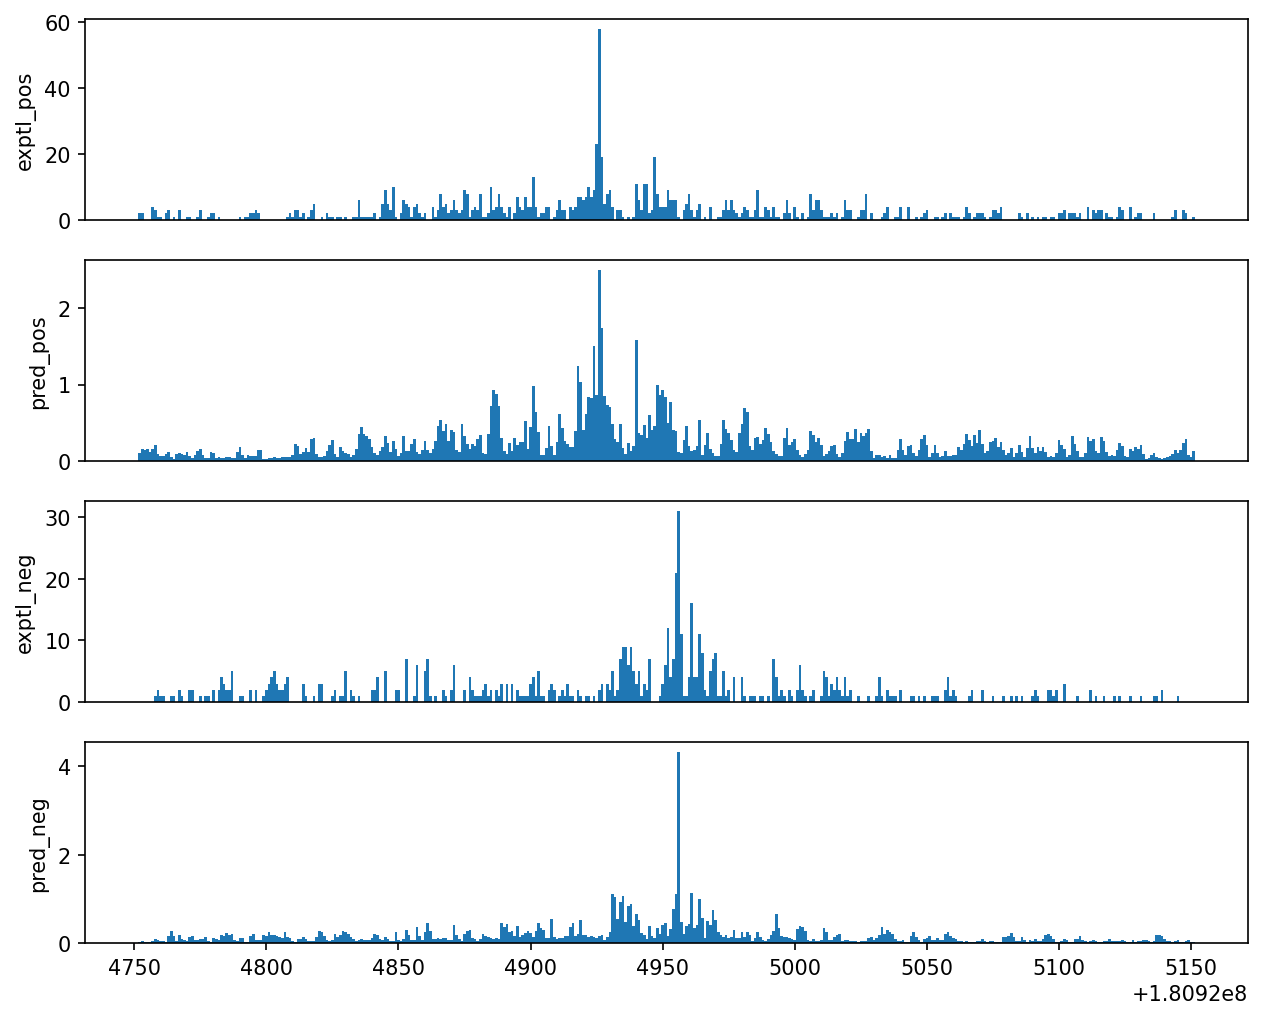

In [57]:
plotTfBigwigs('oct4', 'combined', startPos = 180924752, span=400)

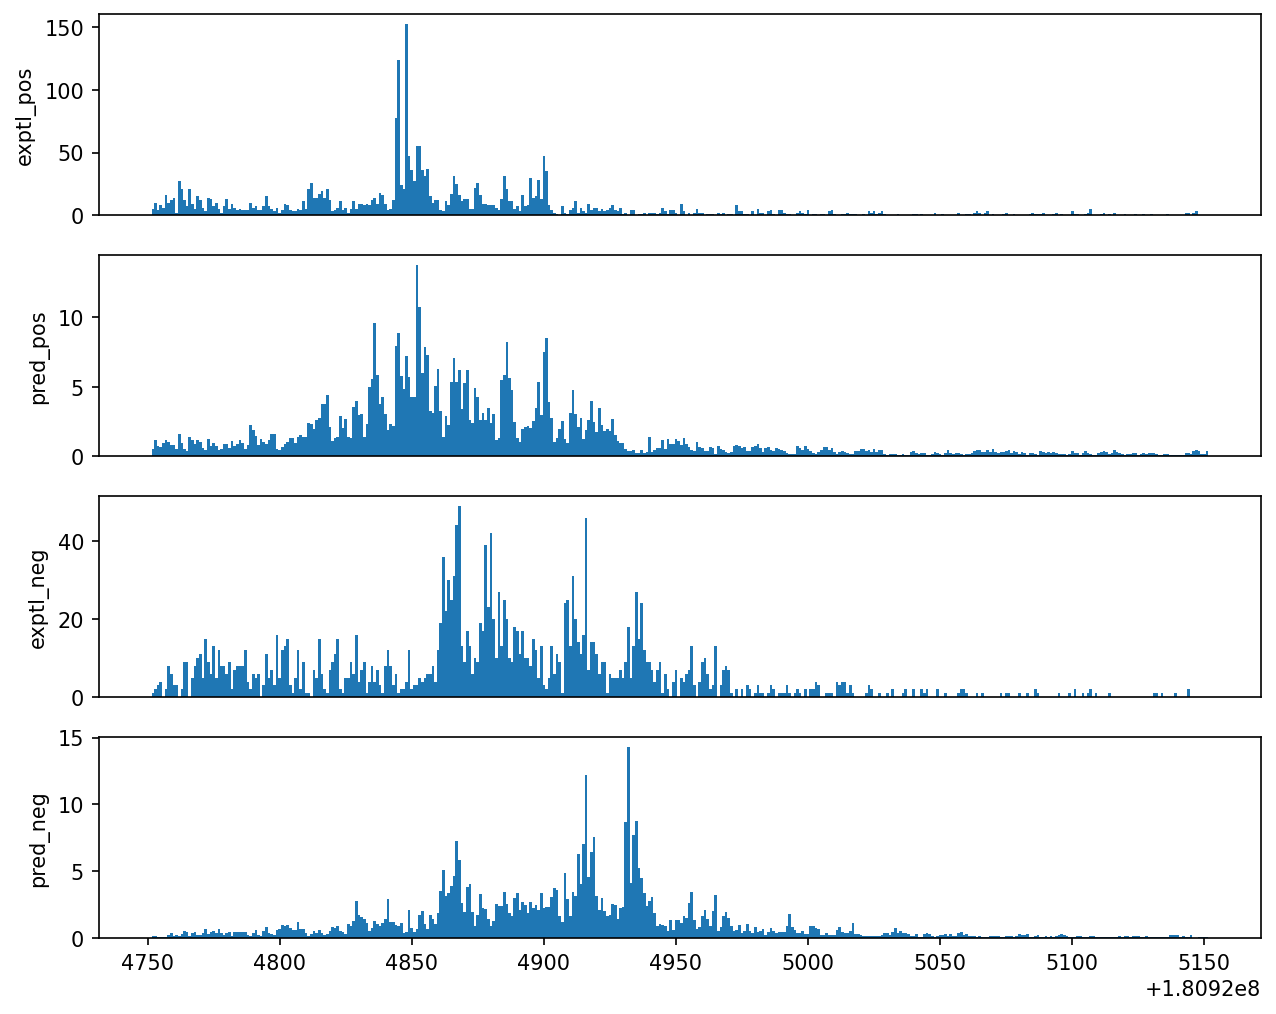

In [58]:
plotTfBigwigs('nanog', 'combined', startPos = 180924752, span=400)

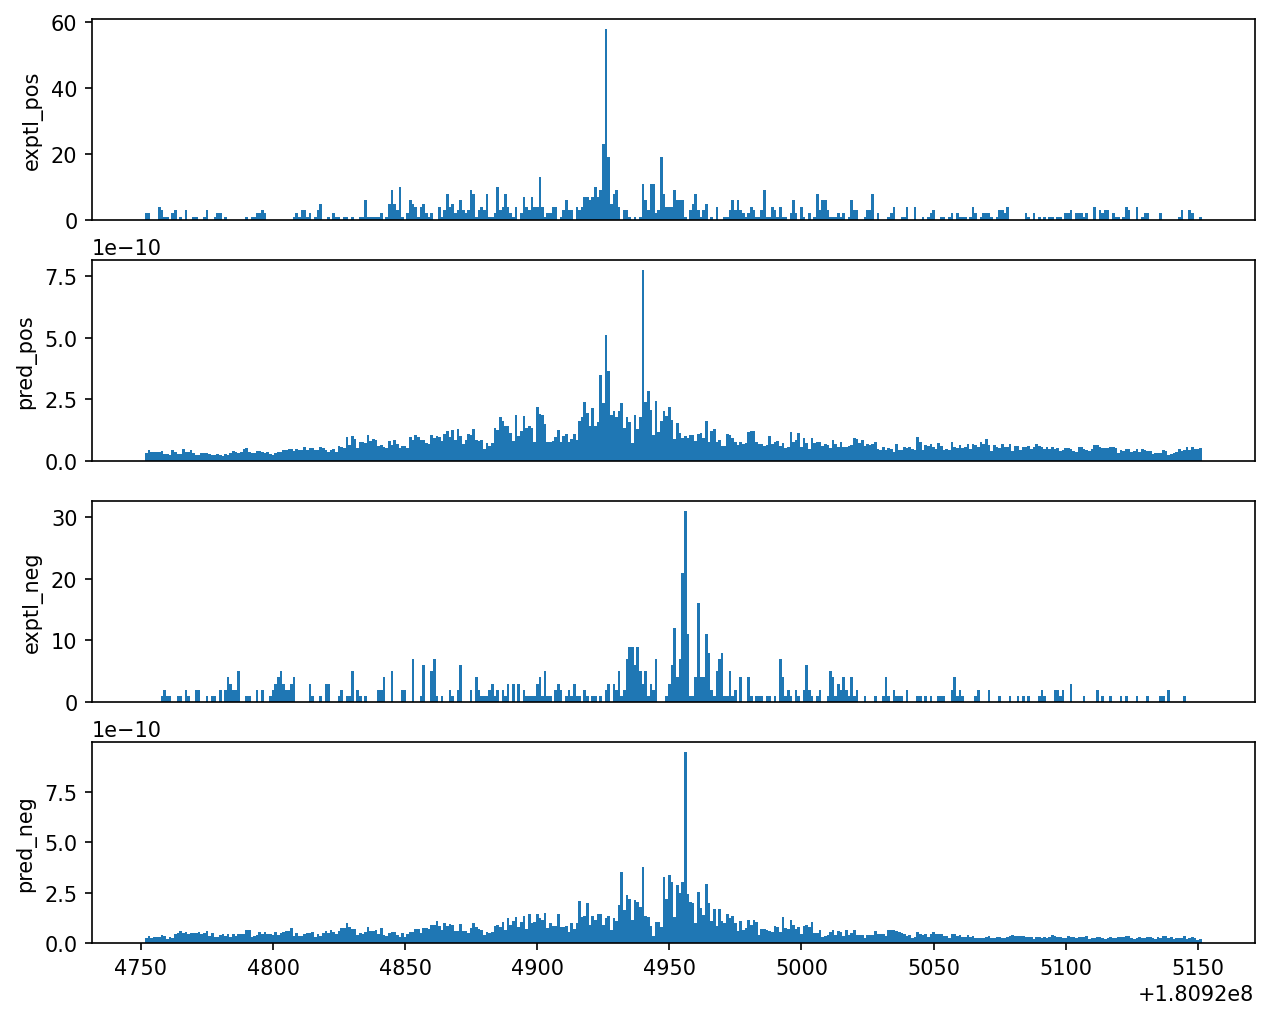

In [59]:
plotTfBigwigs('oct4', 'residual', startPos = 180924752, span=400)

In [60]:
def plotShapBigwigs(tfName, exptName, startPos = 34066036, span=1000, chrom="chr1"):
    plotBws([WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_positive.bw",
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_negative.bw",
             WORKING_DIRECTORY + "/shap/" + tfName + "_profile.bw", 
             WORKING_DIRECTORY + "/shap/" + tfName + "_counts.bw"],
            ["pred_pos", "pred_neg", "profile", "counts"], chrom, startPos, startPos+span)

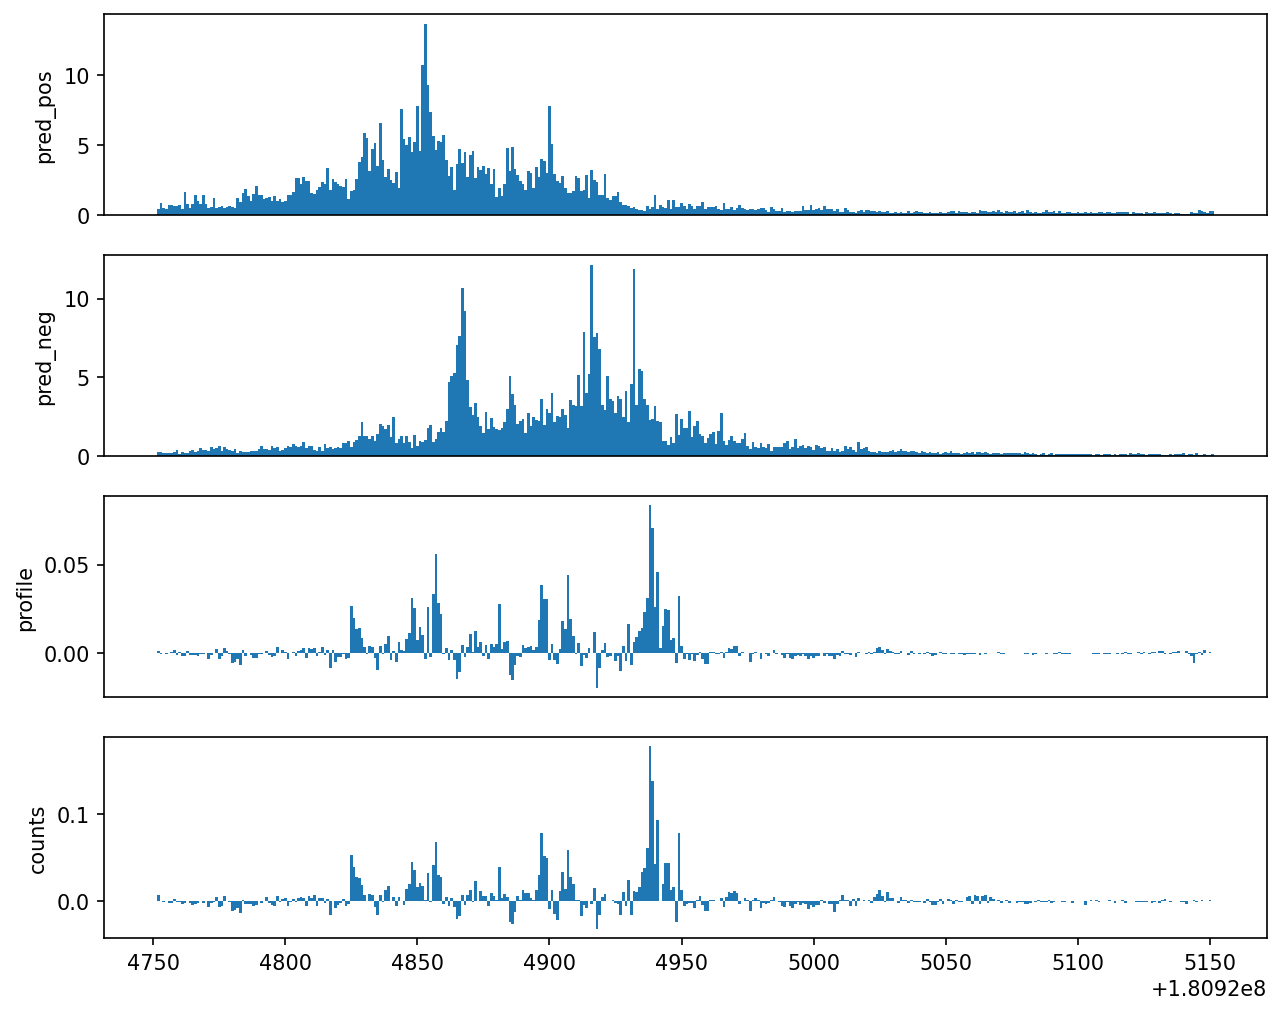

In [61]:
plotShapBigwigs('nanog', 'residual', startPos = 180924752, span=400)

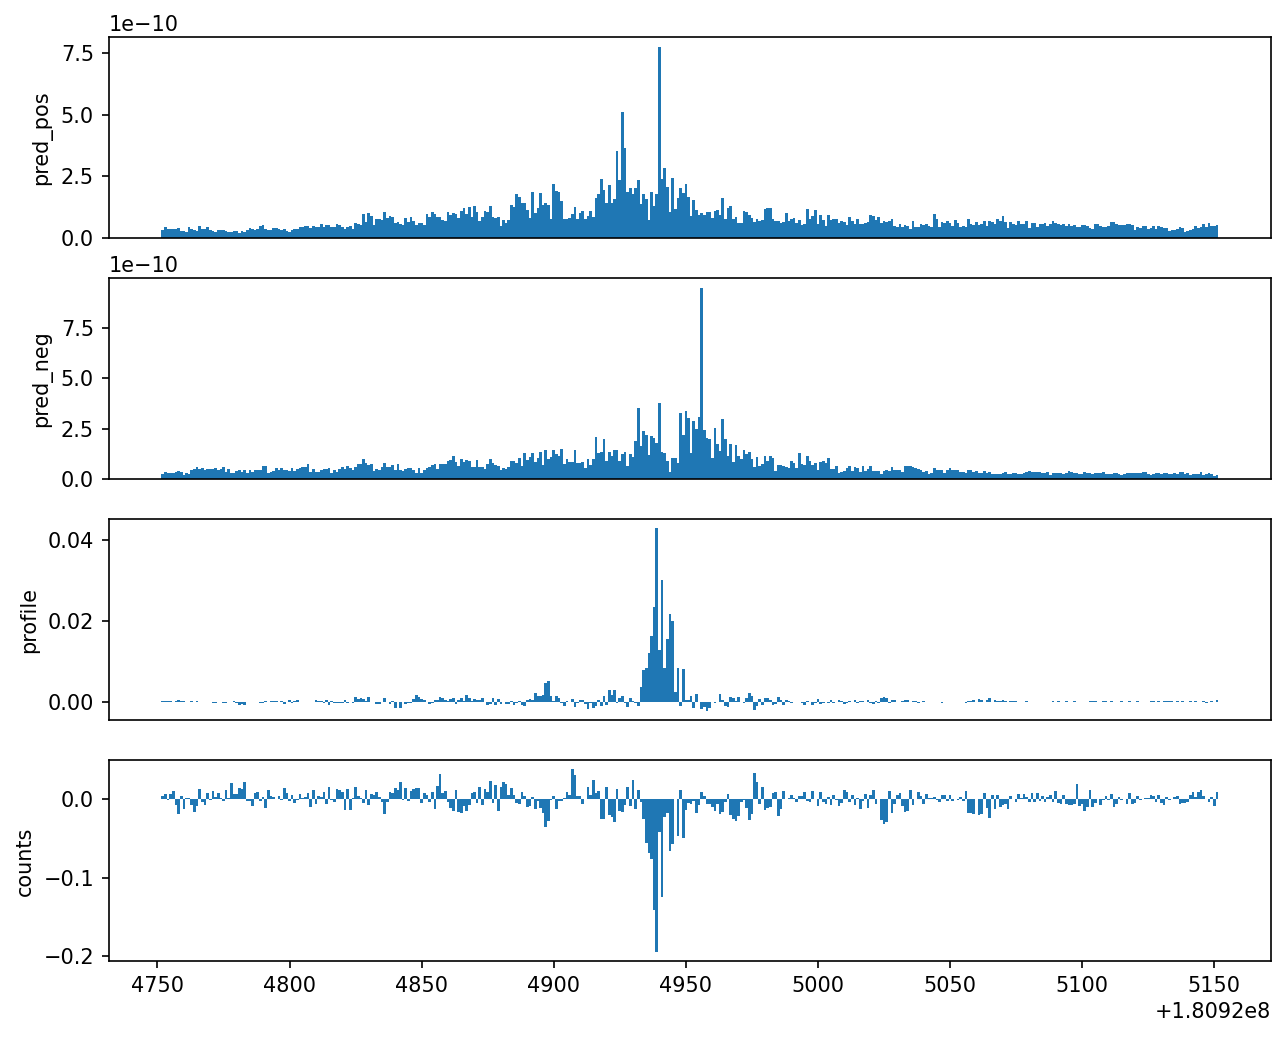

In [62]:
plotShapBigwigs('oct4', 'residual', startPos = 180924752, span=400)

In [63]:
import bpreveal.tools.plots as bprplots
import bpreveal.motifUtils as motifUtils
import tqdm

sox2_profile


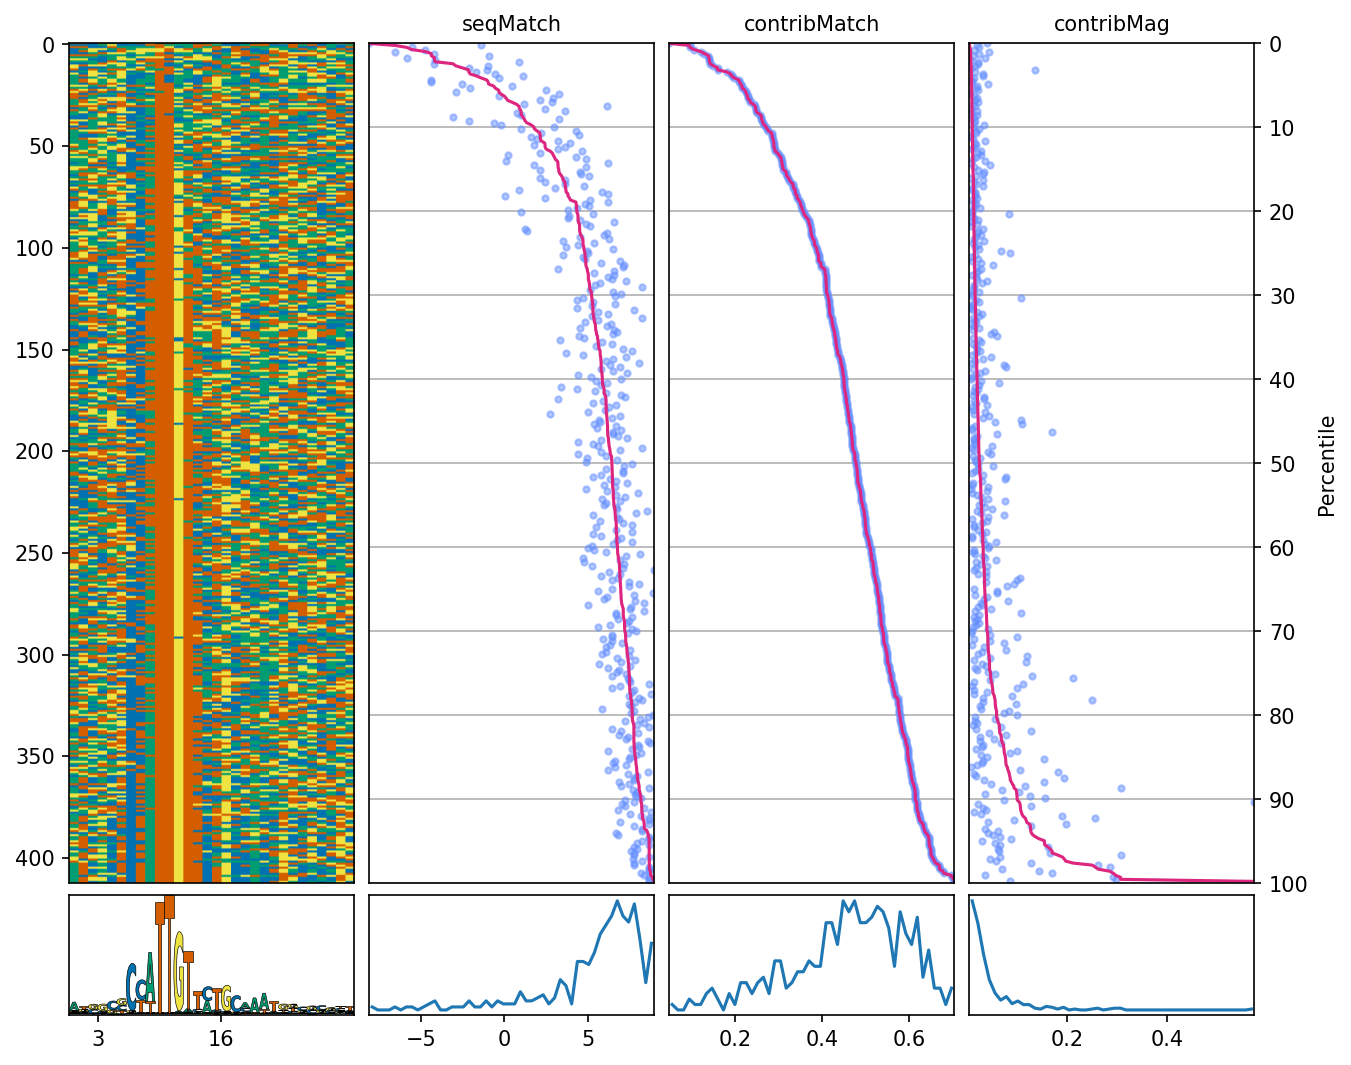

In [64]:
#I'll generate all of those figures and save them.
runName, run = list(patternsToScan.items())[2]
print(runName)
clusterName, cluster = list(run.items())[0]
motif = cluster[0]
pat = motifUtils.Pattern(clusterName + "_patterns", "pattern_{0:d}".format(motif[0]), motif[1])
with h5py.File(WORKING_DIRECTORY + "/modisco/" + runName + "/modisco.h5", "r") as fp:
    pat.loadCwm(fp, 0.3, 3, bgProbs)
    pat.loadSeqlets(fp)
fig = plt.figure()
bprplots.plotModiscoPattern(pat, fig, sortKey = [x.contribMatch for x in pat.seqlets])



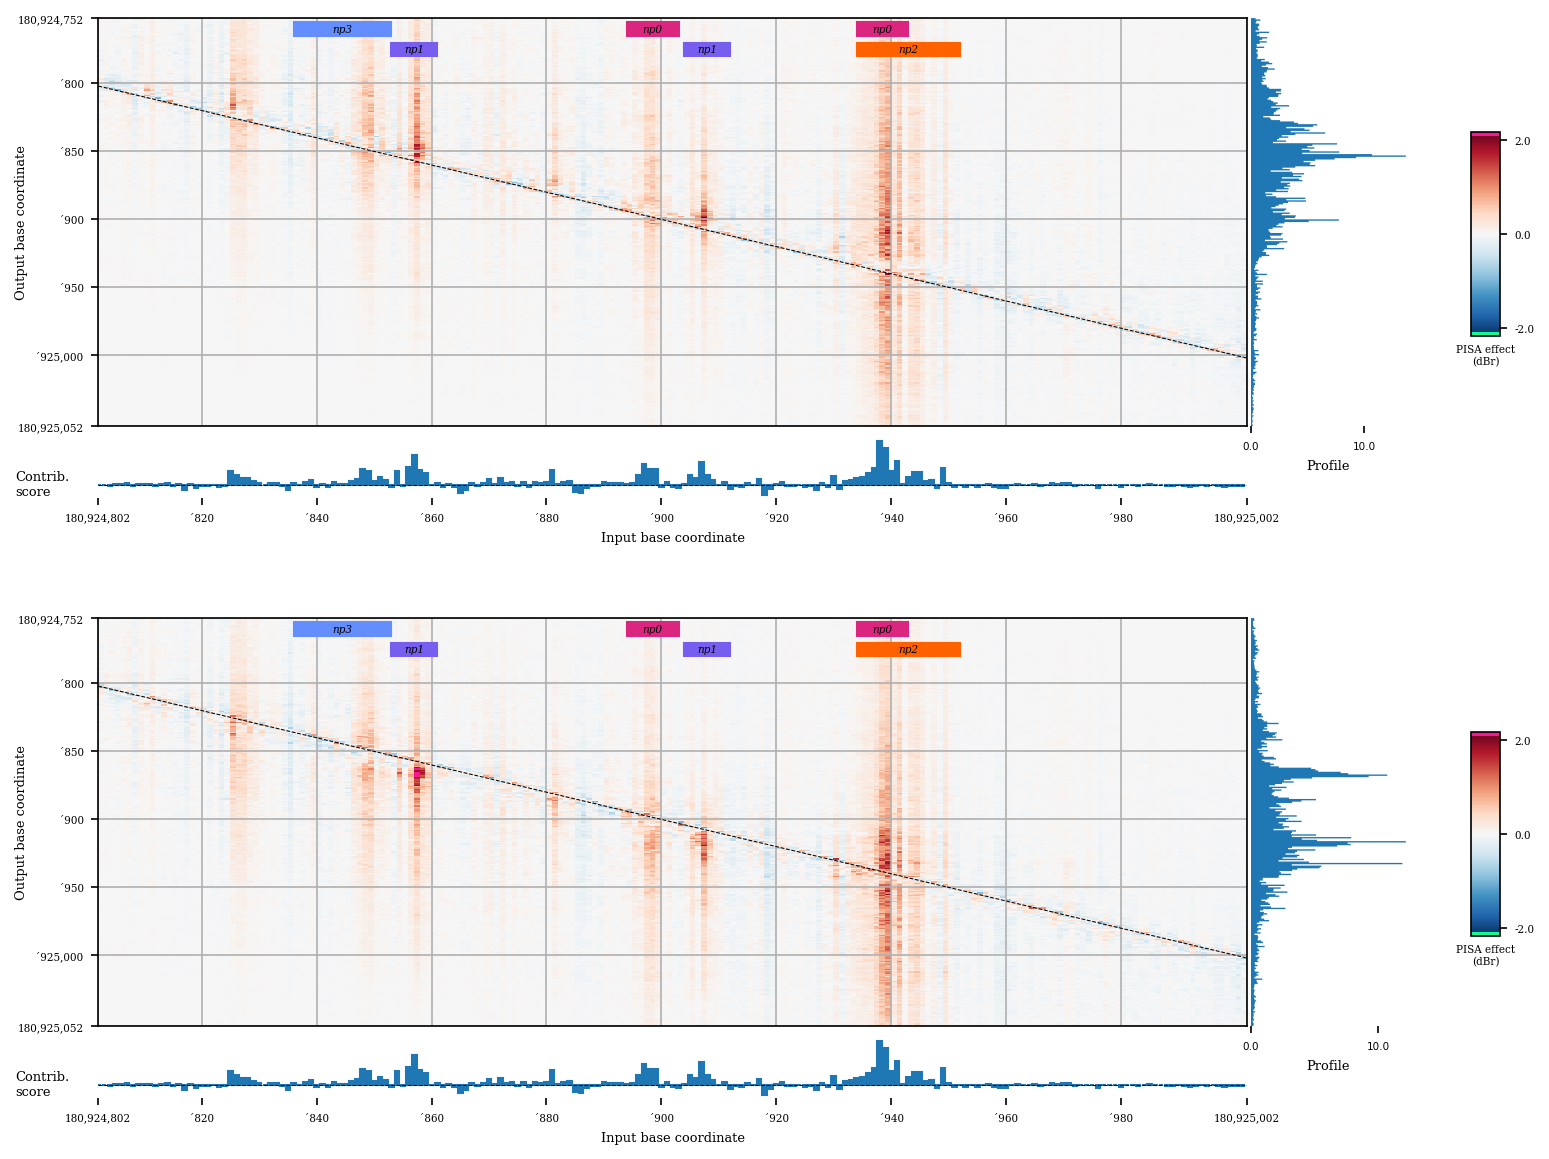

In [65]:
nameColors = dict()
fig = plt.figure()

bprplots.plotPisaWithFiles(WORKING_DIRECTORY + "/shap/pisa_nanog_positive.h5",
                  1150, 200, 300, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/nanog_profile.bw",
                  WORKING_DIRECTORY + "/scan/nanog_profile.bed",
                  WORKING_DIRECTORY + "/pred/nanog_residual_positive.bw",
                  nameColors,
                  fig, [0.1, 0.55, 0.9, 0.4],
                  colorSpan = 0.5,
                  fontsize=5)

bprplots.plotPisaWithFiles(WORKING_DIRECTORY + "/shap/pisa_nanog_negative.h5",
                  1150, 200, 300, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/nanog_profile.bw",
                  WORKING_DIRECTORY + "/scan/nanog_profile.bed",
                  WORKING_DIRECTORY + "/pred/nanog_residual_negative.bw",
                  nameColors,
                  fig, [0.1, 0.05, 0.9, 0.4],
                  colorSpan = 0.5);


In [66]:
import json
from bpreveal import gaOptimize
with open(f"{WORKING_DIRECTORY}/logs/gaOutput.json", "r") as fp:
    j = json.load(fp)
    origProf = np.array(j["origProfile"])
    prof = np.array(j["profile"])

[(1098, 'Ǧ'), (1398, 'G'), (1402, 'G'), (1508, 'Ǎ'), (1572, 'T'), (1582, 'd'), (1631, 'd'), (1753, 'T'), (1847, 'Ǎ'), (1882, 'A')]


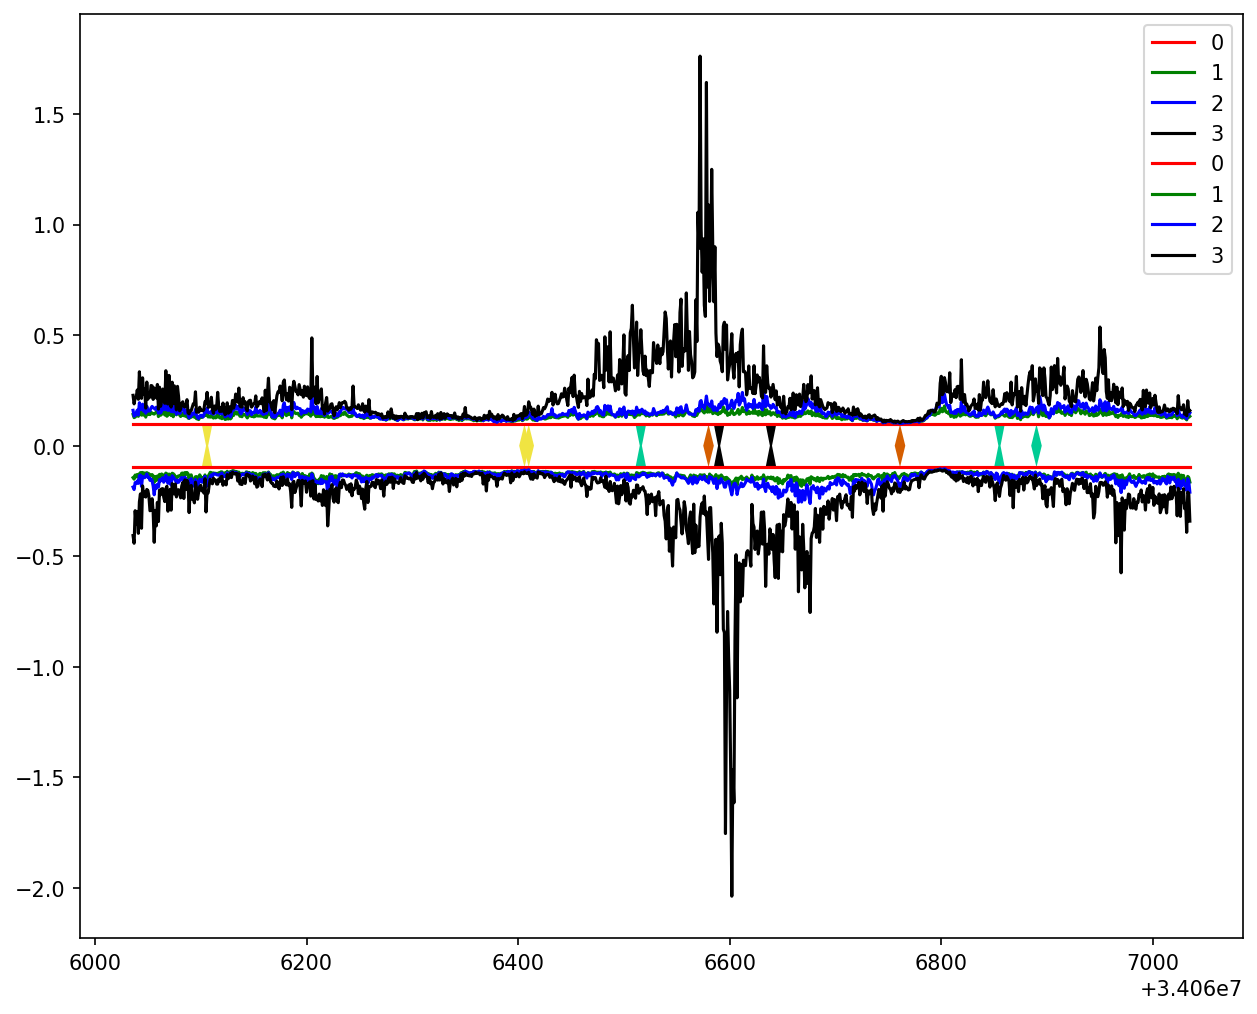

In [67]:
ptr = [(prof[x,:,0], str(x), "rgbk"[x]) for x in range(4)]
ntr = [(prof[x,:,1], str(x), "rgbk"[x]) for x in range(4)]
ax = plt.axes()
cors = gaOptimize.stringToCorruptorList(j["corruptors"])
print(cors)
cors_fix = [(x[0] + 34066036 - (INPUT_LENGTH - OUTPUT_LENGTH) //2, x[1]) for x in cors]
#gaOptimize.plotTrace(ptr, ntr, range(34066036, 34067036), [], gaOptimize.stringToCorruptorList(j["corruptors"]), ax)
gaOptimize.plotTraces(ptr, ntr, range(34066036, 34067036), [], cors_fix, ax)
                      #bpreveal.gaOptimize.plotTraces(xvals: ndarray[Any, dtype[float32]], annotations: list[ANNOTATION_T], corruptors: list[Corruptor], ax: Axes)

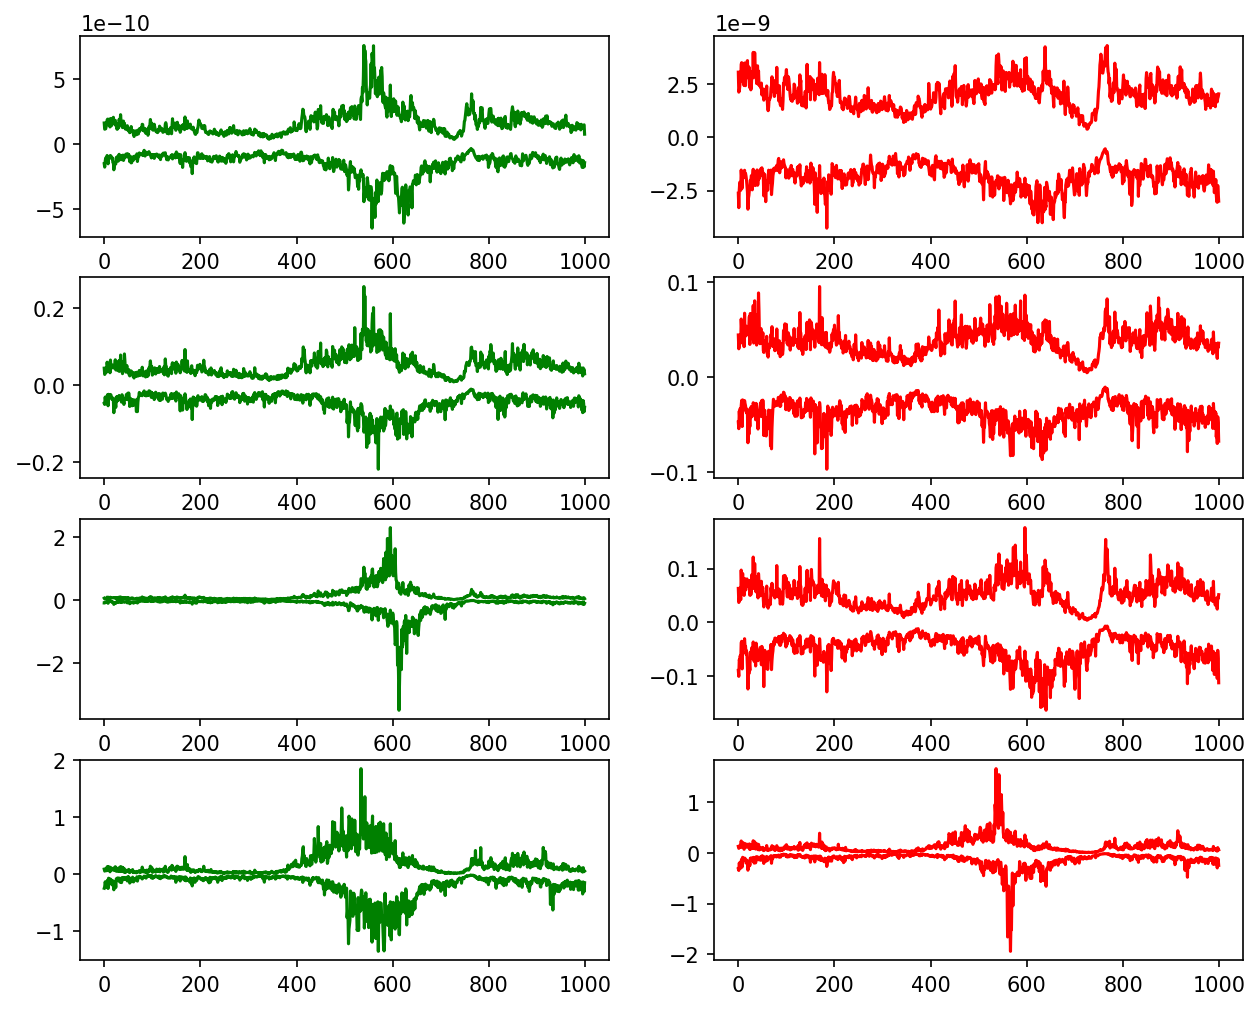

In [68]:
for i in range(4):
    plt.subplot(421+i*2)
    plt.plot(origProf[i,:,0], "g-")
    plt.plot(-origProf[i,:,1], "g-")
    plt.subplot(422+i*2)
    plt.plot(prof[i,:,0], "r-")
    plt.plot(-prof[i,:,1], "r-")

        